In [1]:
import numpy as np
import matplotlib.pyplot as mp
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
#from mpl_toolkits.basemap import Basemap as bmap
import shapely.geometry as sgeom
import cftime

import xarray as xr
import datetime as dt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from scipy import signal

In [2]:
#var_name = 'ZMDQ' ; vscale = 86400*1000. ; vunits = 'g/kg/day' ; long_name = 'Humidity Tendency due to Deep Convection'
#var_name = 'ZMDT' ; vscale = 86400. ; vunits = 'g/kg/day' ; long_name = 'Temperature Tendency due to Deep Convection'
#var_name = 'OMEGA' ; vscale = 0.01*3600. ; vunits = 'mb/day' ; long_name = 'Vertical Velocity'
#var_name = 'RVMTEND_CLUBB' ; vscale = 86400*1000. ; vunits = 'g/kg/day' ; long_name = 'Humidity Tendency due to CLUBB'
var_name = 'CMFDQ' ; vscale = 86400*1000. ; vunits = 'g/kg/day' ; long_name = 'Humidity Tendency due to UW Shallow Convection'

date_range = ["0001-06-01","0001-12-01"]

#reg_a = [-15,15,90,150.] # LATS first then LONS
#reg_a = [-10,10,120.,160] # lats, lons averaging region - m. Continent
reg_a = [7.5,10,220.,240] # lats, lons averaging region. - E. Pac 1
#reg_a = [5,12,270,280] # lats, lons averaging region. - E. Pac 2
#reg_a = [5,12,240,270] # lats, lons averaging region. - E. Pac 2

#run_names = ['f.e20.FHIST.f09_f09.cesm2_1_cam5.001','f.e20.FHIST.f09_f09.cesm2_1.001']
#case_names = np.array(['CAM5','CAM6'])

#run_names = ['f.e20.FHIST.f09_f09.cesm2_1.001']
#case_names = np.array(['CAM6'])

run_names = ['f.e20.FHIST.f09_f09_cam5.001']
case_names = np.array(['CAM5'])


reg_a_out = '%d-%dW_%.1f-%dN' % (360-reg_a[2],360-reg_a[3],reg_a[0],reg_a[1])
reg_a_str = '%d-%d\u00b0W %.1f-%d\u00b0N' % (360-reg_a[2],360-reg_a[3],reg_a[0],reg_a[1])

-- Region ->  -140.0 7.5 -120.0 10



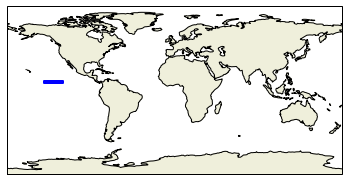

-Case - CAM5 f.e20.FHIST.f09_f09_cam5.001


FileNotFoundError: [Errno 2] No such file or directory: b'/glade/scratch/rneale/f.e20.FHIST.f09_f09_cam5.001/tseries/f.e20.FHIST.f09_f09_cam5.001_clim_dmeans_ts_CMFDQ.nc'

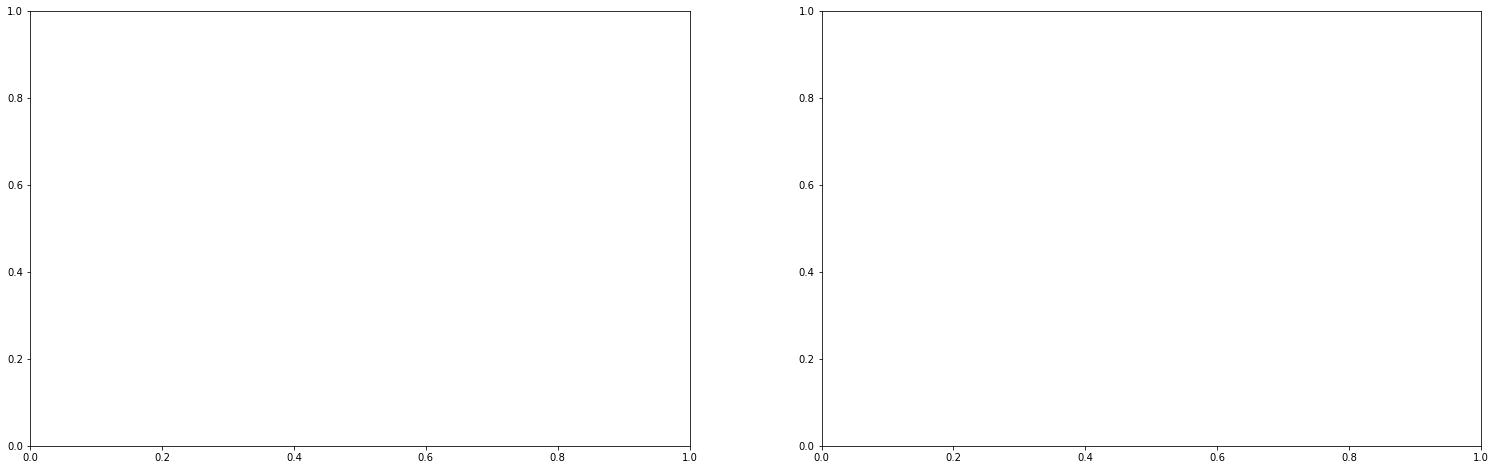

In [3]:
ncases = case_names.size


# Plotting #
cmin,cmax,dcont = -8.,8.,0.2
plevels =  np.arange(cmin,cmax+dcont,dcont,dtype=np.float)


## Plot map with averaging location

figm = mp.figure()

axm = figm.add_subplot(projection=ccrs.PlateCarree())

r1 = reg_a[2] if reg_a[3] <=180. else reg_a[2]-360.
r2 = reg_a[0] 
r3 = reg_a[3] if reg_a[3] <=180. else reg_a[3]-360.
r4 = reg_a[1] 


print('-- Region -> ',r1,r2,r3,r4)
print('')

extent_box = sgeom.box(r1,r2,r3,r4)

axm.add_geometries([extent_box], ccrs.PlateCarree(), facecolor='none',
                          edgecolor='blue', linewidth=2)
axm.add_feature(cfeature.LAND)
axm.add_feature(cfeature.COASTLINE)
mp.show()

fig, ax = mp.subplots(1,2,figsize=(26, 8))



# Plotting

for ic in range(ncases):
    

    case = case_names[ic]
    run = run_names[ic]

    print('-Case - '+case+' '+run)
    
    file_in = '/glade/scratch/rneale/'+run+'/tseries/'+run+'_clim_dmeans_ts_'+var_name+'.nc'
    file_ptr = xr.open_dataset(file_in,engine='netcdf4')
    var_in = file_ptr[var_name].loc[date_range[0]:date_range[1],:,reg_a[0]:reg_a[1],reg_a[2]:reg_a[3]] 
    
    var_m =  var_in.mean(dim=['lat','lon'])*vscale
    lev = var_m.lev
    time = var_m.time
    nt = time.size
    
  

# Time
    date_form = DateFormatter("%b")
    doy = time.dt.strftime('%j')
    
    var_mt = var_m.transpose()
    var_mt['time'] = doy

## Month axes between ticks
    ax[ic].xaxis.set_major_formatter(date_form)
    ax[ic].xaxis.set_minor_formatter(date_form)
    ax[ic].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax[ic].xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=16,interval=1))
    ax[ic].xaxis.set_major_formatter(ticker.NullFormatter())


   
    ax[ic].xaxis_date()    
    ax[ic].invert_yaxis()
    ax[ic].set_ylabel('Pressure (mb)') 
    ax[ic].set_xlabel("Time of Year")  
    ax[ic].xaxis.grid(True)
    
# Filter
    for ii in range(0,10): #Simple multiple passes of a 1-2-1 filter
        var_mt[:,1:nt-2] = 0.25*(var_mt[:,0:nt-3].values+2*var_mt[:,1:nt-2].values+var_mt[:,2:nt-1].values)

    ax[ic].set_title(case,fontsize=15)
    aplot = ax[ic].contourf(doy,lev,var_mt,levels=plevels,cmap='seismic_r')
    aplot = ax[ic].contour(doy,lev,var_mt,levels=plevels,colors='black')
    ax[ic].clabel(aplot, aplot.levels)
    
ptitle = var_name+' - '+long_name+' ('+vunits+') - '+reg_a_str
mp.suptitle(ptitle,fontsize=20)
mp.savefig('daily_ts.plev_'+var_name+'_'+reg_a_out+'_'+date_range[0]+'_to_'+date_range[1]+'.png', dpi=300)  
    

In [ ]:
def gauss_kern(size, sizey=None):
    """ Returns a normalized 2D gauss kernel array for convolutions """
    size = int(size)
    if not sizey:
        sizey = size
    else:
        sizey = int(sizey)
    x, y = np.mgrid[-size:size+1, -sizey:sizey+1]
    g = np.exp(-(x**2/float(size)+y**2/float(sizey)))
    return g / g.sum()

def blur_image(im, n, ny=None) :
    """ blurs the image by convolving with a gaussian kernel of typical
        size n. The optional keyword argument ny allows for a different
        size in the y direction.
    """
    g = gauss_kern(n, sizey=ny)
    improc = signal.convolve(im,g, mode='valid')
    return(improc)